In [11]:
from fixed_effects import run_fixed_effects_on_flattened
from random_effects import run_rand_effects_on_flattened
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
path = "./../../data/11_flattenned/flatten_variables_pct.csv"

Simple Fixed Effects

In [13]:
results_simple_fix = run_fixed_effects_on_flattened(path)
results_end_of_year_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates = ["=12/2019", "=12/2020", "=12/2021", "=12/2022", "=12/2023"], 
                                  dummy_names = ["is_END19", "is_END20", "is_END21", "is_END22", "is_END23"])
results_war_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates=[">02/2022"], 
                                  dummy_names=["is_WAR"])
results_both_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates = ["=12/2019", "=12/2020", "=12/2021", "=12/2022", "=12/2023", ">02/2022"], 
                                  dummy_names = ["is_END19", "is_END20", "is_END21", "is_END22", "is_END23", "is_WAR"])
results_random = run_rand_effects_on_flattened(path)

lst = [(results_simple_fix, "Simp__F"), 
       (results_end_of_year_fixed, "Years_F"),
       (results_war_fixed, "War_F"),
       (results_both_fixed, "All_F"),
       (results_random, "Random")]

=============================== Fixed Effects =================================
                            OLS Regression Results                            
Dep. Variable:                    NIM   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.588
Date:                Thu, 02 May 2024   Prob (F-statistic):           3.28e-07
Time:                        18:00:12   Log-Likelihood:                 301.22
No. Observations:                 550   AIC:                            -560.4
Df Residuals:                     529   BIC:                            -469.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

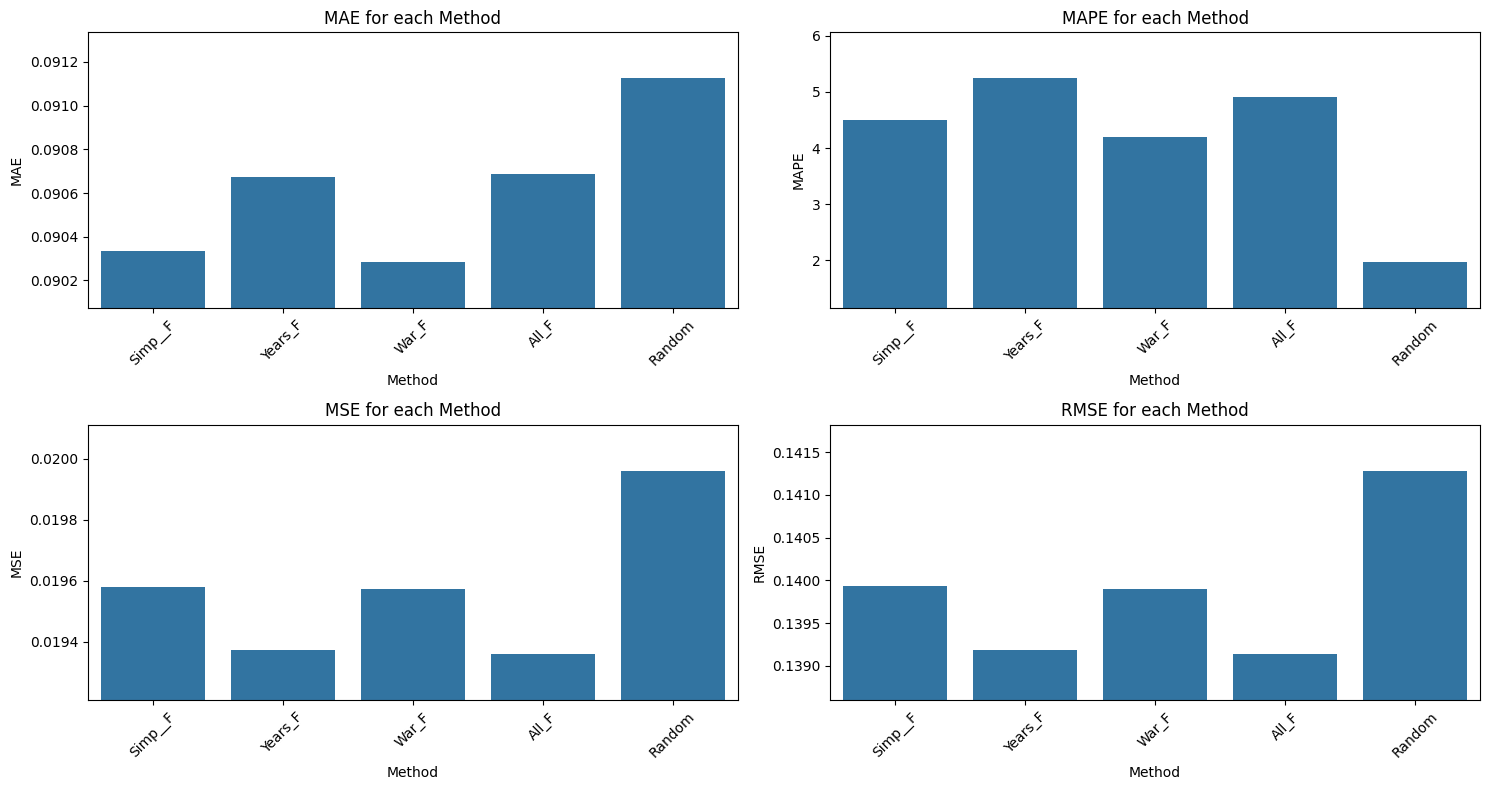

In [26]:
dct = {"Method":[], "MAE":[], "MAPE":[], "MSE":[], "RMSE":[]}

for i in lst:
    r = i[0].get_estimators(silence=True)
    dct["Method"].append(i[1])
    dct["MAE"].append(r["MAE"])
    dct["MAPE"].append(r["MAPE"])
    dct["MSE"].append(r["MSE"])
    dct["RMSE"].append(r["RMSE"])

df = pd.DataFrame(dct)
# results.style.background_gradient(cmap='Blues')

error_methods = ["MAE", "MAPE", "MSE", "RMSE"]
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

for i, error_method in enumerate(error_methods):
    ax = axs[i]
    sns.barplot(x="Method", y=error_method, data=df, ax=ax)
    ax.set_title(f"{error_method} for each Method")
    ax.set_xlabel("Method")
    ax.set_ylabel(error_method)
    ax.tick_params(axis='x', rotation=45)
    diff = (df[error_method].max() - df[error_method].min()) / 4
    ax.set_ylim(df[error_method].min() - diff, df[error_method].max() + diff)

fig.tight_layout()
plt.show()

In [15]:
# - - - F-TEST - - -
# f_h = "is_END19 = 0, is_END20 = 0, is_END21 = 0, is_END22 = 0, is_END23 = 0"
# results_end_of_year_fixed.res.f_test(f_h)